In [1]:
import numpy as np
import lDGA.config as cfg
import lDGA.dmft_reader as dmft_reader
import lDGA.bse as bse

Running cmake --build & --install in /Users/eminmoghadas/Documents/phd/DGA/build


### load dmft data

In [2]:
# example file
dmft_file = "b53_u2_4_2part-2022-11-19-Sat-07-10-47.hdf5"

In [3]:
dga_cfg = cfg.DGA_Config(dmft_file)
reader = dmft_reader.DMFT_Reader(dga_cfg)

### calculate lattice chi_q

In [4]:
beta = dga_cfg.dmft_dict['beta']
mu = dga_cfg.dmft_dict['mu']
g = dga_cfg.dmft_dict['giw']
s = dga_cfg.dmft_dict['siw']
g2 = dga_cfg.dmft_dict['g4iw']
niwf = dga_cfg.niwf
n4iwf = dga_cfg.n4iwf
n4iwb = dga_cfg.n4iwb
iw = 0
iw_idx = iw + n4iwb
kdim = dga_cfg.kdim
nk = dga_cfg.nk
q = [0,0]

chi0 = bse.local_bubble(beta, g, iw)
chi0_q = bse.lattice_bubble(beta, mu, g, s, kdim, nk, iw, q, niwf)
F_loc_c, F_loc_s = bse.F_r_local(beta, chi0, g2[...,iw_idx], g, niwf, n4iwf)
chi_q_c, chi_q_s = bse.chi_ladder_q(beta, chi0, chi0_q, F_loc_c, F_loc_s, niwf, n4iwf)

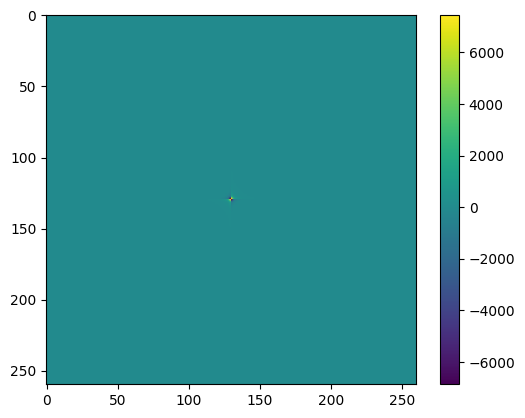

In [5]:
import matplotlib.pyplot as plt
plt.imshow(chi_q_c.real)
plt.colorbar()